In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Downloading Data from Google Drive


In [ ]:
# Download the data from the drive.
!gdown 1dDqOa4aSrc0o1pHOOoI6aR67_n9EsrgT

/usr/local/lib/python3.8/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1ojaJLmM6sar58i0WZ9_C5j7gwBc1chLl
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1ojaJLmM6sar58i0WZ9_C5j7gwBc1chLl/view?usp=share_link
To: /content/view?usp=share_link
71.1kB [00:00, 4.12MB/s]


In [ ]:
# Extract the donwloaded zip file.
!unzip DL_Assignment_1_Data.zip

unzip:  cannot find or open DL_Assignment_1_Data.zip, DL_Assignment_1_Data.zip.zip or DL_Assignment_1_Data.zip.ZIP.


# Loading Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255, # normalize the image pixels
    rotation_range=30, # randomly rotate by up to 30 degrees
    width_shift_range=0.2, # randomly shift the image horizontally by up to 20%
    height_shift_range=0.2, # randomly shift the image vertically by up to 20%
    horizontal_flip=True, # randomly choose to flip the image horizontally
    validation_split=0.1 # 10% validation data
)

# We use the image data generator to load images lazily. If we try to load them
# all at once, the GPU may crash due to not having enough memory.
#
# Using a batch size of 64 speeded up training at the cost of accuracy, so we
# decided to settle with 32.
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    '/content/Data/train',
    subset='training',
    class_mode='sparse',
    batch_size=batch_size,
)
validation_generator = train_datagen.flow_from_directory(
    '/content/Data/train',
    subset='validation',
    class_mode='sparse',
    batch_size=batch_size,
)

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    '/content/Data/test',
    class_mode='sparse',
    batch_size=128,
)

In [ ]:
# Load the classes text file.
CLASSES = []
with open('/content/Data/Classes.txt', 'r') as f:
  # Execute the text file as a python program.
  exec(f.read())

CLASSES

# Visualising Data

In [ ]:
from pandas import DataFrame
from collections import Counter

# `Counter` returns a dictionary whose keys are the given list's values
# and whose values are the number of occurances of those keys. We use
# this class to count the number of samples for each of the 104 classes.
train_label_counters = Counter(train_generator.labels).values()
validation_label_counters = Counter(validation_generator.labels).values()
test_label_counters = Counter(test_generator.labels).values()
# Show the counters as a DataFrame table.
data = {
    'Train': train_label_counters,
    'Validation': validation_label_counters,
    'Test': test_label_counters
}
DataFrame(data, index=CLASSES)

,Train,Validation,Test
pink primrose,245,27,79
hard-leaved pocket orchid,24,2,7
canterbury bells,123,13,40
sweet pea,28,3,9
wild geranium,23,2,7
...,...,...,...
blanket flower,115,12,37
trumpet creeper,90,10,29
blackberry lily,37,4,12
common tulip,31,3,10


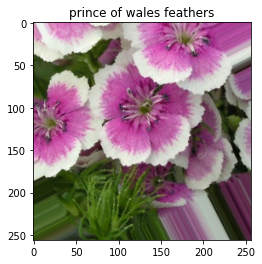

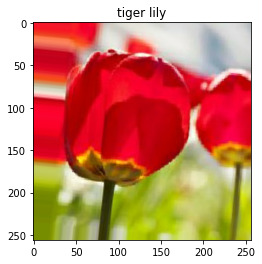

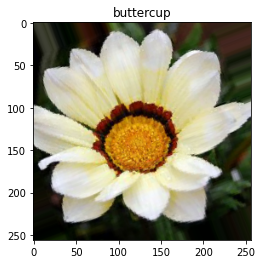

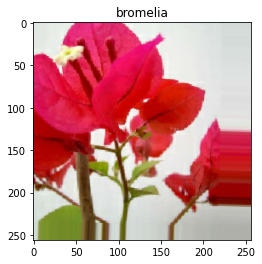

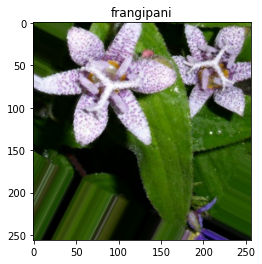

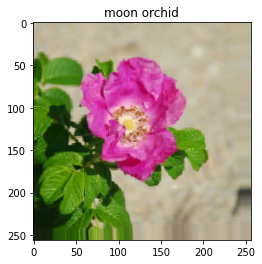

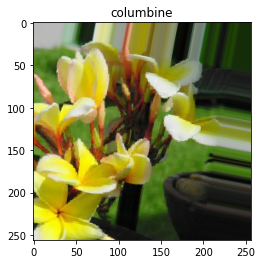

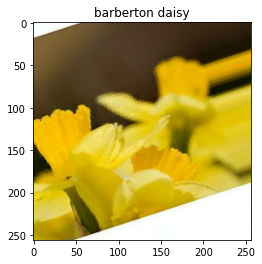

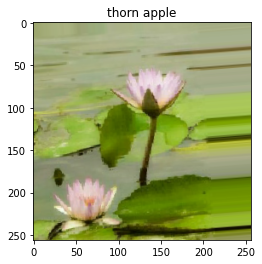

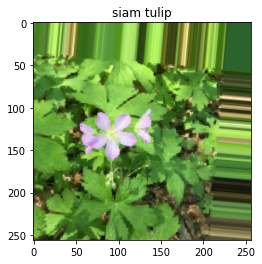

In [ ]:
import matplotlib.pyplot as plt

# Get a batch from the sequence of training data
image_batch, label_batch = train_generator.next()
for i in range(10):
  # Each batch is stored as a tuple of image and label arrays. Show 5 of them.
  # Plot each image in its own figure
  plt.figure(i + 1)
  plt.imshow(image_batch[i])
  # Show the class name as the image title
  label = int(label_batch[i])
  plt.title(CLASSES[label])
# Notice the effect of image augmentation on some of the data

# Common Helpers
Common functions across all models to reduce duplication

In [ ]:
!pip install tensorflow-addons
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 48.1 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd

In [ ]:
def test_model(model):
  """
  Tests the given model using the test dataset.

  Returns:
  --------
  Two arrays, the output of the model and the true labels.
  """
  output, labels = [], []
  # Iterate over all test data
  while len(labels) != 3712:
    # Generate the next batch
    image_batch, label_batch = test_generator.next()
    # Pass it to our model and add the result to our lists.
    # Use `verbose=0` to compute the result silently.
    batch_output = model.predict(image_batch, verbose=0)
    output.extend(batch_output)
    labels.extend(label_batch)
  # Convert the lists to numpy array to have access to methods
  # such as `shape`, `size`, etc. They are also shown in a nicer
  # way in the Jupyter console. Also, the labels are floats for
  # some reason, so we convert them to integers.
  return np.array(output), np.array(labels).astype(int)

In [ ]:
def get_predicted_labels(output):
  """
  Returns the labels predicted by the model.

  Parameters:
  -----------
  output: The output returned from `model.predict()`.
  """
  # Replace each row with the index of the maximum value in that row.
  return np.argmax(output, axis=1)

In [ ]:
def get_confusion_matrix(labels, predicted_labels):
  """
  Returns the confusion matrix of a model as a DataFrame.

  Parameters:
  -----------
  labels: The true labels.
  predicted_labels: The labels predicted by the model.
  """
  matrix = tf.math.confusion_matrix(
      labels=labels,
      predictions=predicted_labels,
      num_classes=len(CLASSES),
  )
  # We convert the matrix to a numpy array because tensorflow tensors
  # take up a lot of space when shown in the console. We also replace
  # the row and column indices with the class names.
  return pd.DataFrame(matrix.numpy(), columns=CLASSES, index=CLASSES)

In [ ]:
def compute_f1score(output, labels):
  """
  Returns the F1 score of a model's output.

  Parameters:
  -----------
  output: The output of the model.
  labels: The true labels.
  """
  score = tfa.metrics.F1Score(num_classes=len(CLASSES))
  # We convert ours sparse labels to categorical labels to match the output shape.
  categorical_labels = tf.keras.utils.to_categorical(labels)
  score.update_state(categorical_labels, output)
  return score.result().numpy()

In [ ]:
def most_confusing_classes(count, f1_score):
    """
    Returns a list of the most confusing classes
    in the order of increasing F1 score.

    Parameters:
    -----------
    count: The number of classes to return.
    f1_score: The f1 score of each class.
    """
    sorted_labels = np.argsort(f1_score)[0 : count]
    return [ CLASSES[label] for label in sorted_labels ]




# Model from Scratch

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Notes:
# - Using "same" padding either decreased the model's accuracy or kept it the same.
# - Make the model any deeper didn't result in better performance.
# - Using batch normalizastion after max pooling raised validation accuracy from
# the range of 30s to the range of 40s.
my_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(256, 256, 3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=64, kernel_size=3, activation='relu'),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=3, activation='relu'),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=3, activation='relu'),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(len(CLASSES), activation='softmax'),
])

# Note on the "epsilon" parameter:
# I read in the docs that the default 1e-7 default value isn't usually a good
# choice, so I went with the suggested value 0.1 and (I think?) it slightly
# improved accuracy.
#
# I also tried learning rate decay, but it made training way too slow.
my_model.compile(
    optimizer=Adam(learning_rate=1e-3, epsilon=0.1),
    loss=SparseCategoricalCrossentropy(),
    metrics='accuracy',
)

In [ ]:
# Load the previously saved weights from the drive
my_model.load_weights('/content/drive/MyDrive/Checkpoint/Scratch_model/checkpoint')

## Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras

# Stop training early if, after 5 epochs, validation accuracy doesn't increase.
stop_early = EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True, # restore the model back to the best state
)

# After each poch, save the weights if they result in better accuracy.
save_weights = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Checkpoint/checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

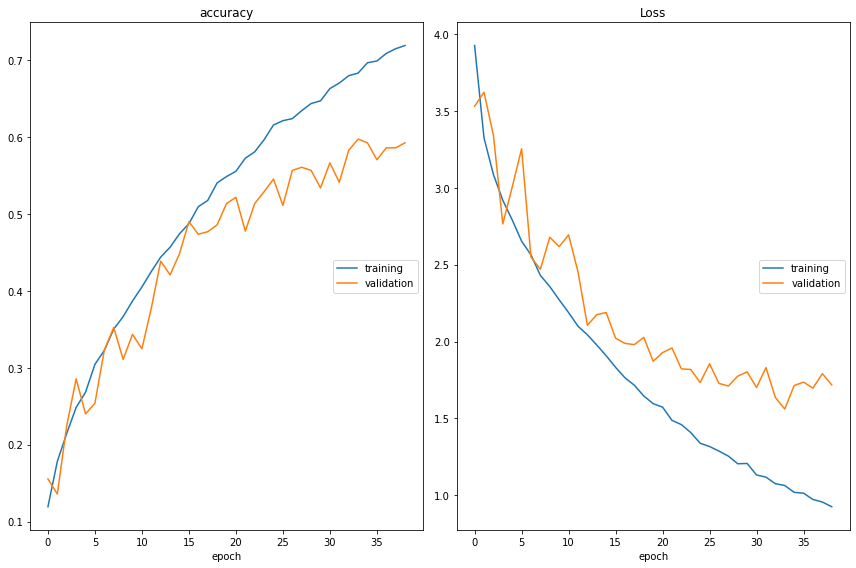

accuracy
	training         	 (min:    0.119, max:    0.719, cur:    0.719)
	validation       	 (min:    0.136, max:    0.597, cur:    0.592)
Loss
	training         	 (min:    0.925, max:    3.926, cur:    0.925)
	validation       	 (min:    1.561, max:    3.621, cur:    1.718)
361/361 [==============================] - 212s 586ms/step - loss: 0.9255 - accuracy: 0.7189 - val_loss: 1.7179 - val_accuracy: 0.5924


In [ ]:
# `PlotLossesKeras` plots the accuracy and loss after each epoch,
# which is useful for evaluating training performance in real time.
result = my_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[stop_early, save_weights, PlotLossesKeras()],
)

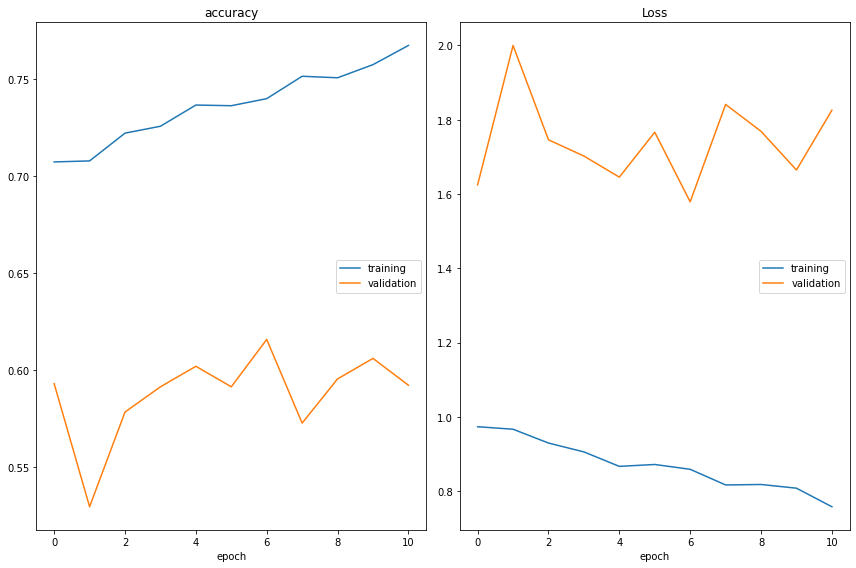

accuracy
	training         	 (min:    0.707, max:    0.768, cur:    0.768)
	validation       	 (min:    0.530, max:    0.616, cur:    0.592)
Loss
	training         	 (min:    0.758, max:    0.973, cur:    0.758)
	validation       	 (min:    1.579, max:    2.000, cur:    1.826)
361/361 [==============================] - 209s 577ms/step - loss: 0.7578 - accuracy: 0.7675 - val_loss: 1.8257 - val_accuracy: 0.5924
Epoch 12/20
276/361 [=====================>........] - ETA: 45s - loss: 0.7355 - accuracy: 0.7756

In [ ]:
my_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[stop_early, save_weights, PlotLossesKeras()],
)

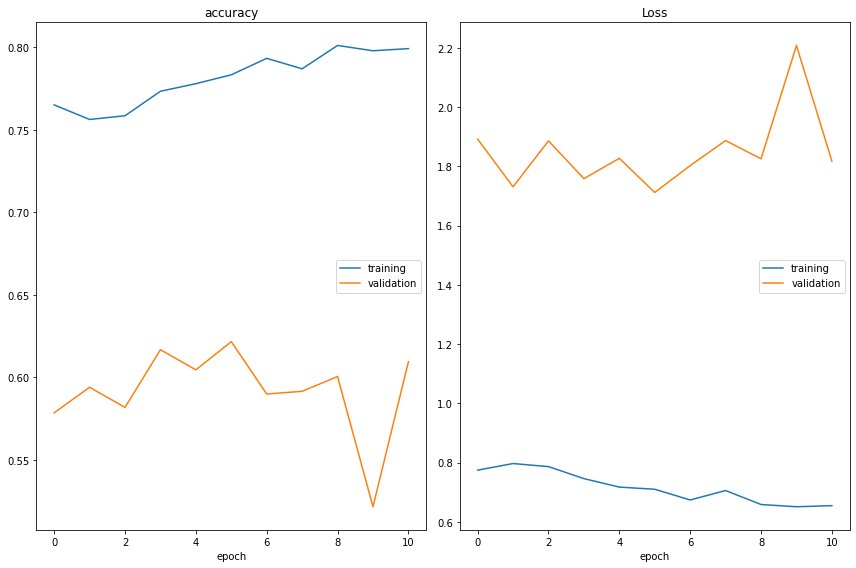

accuracy
	training         	 (min:    0.756, max:    0.801, cur:    0.799)
	validation       	 (min:    0.522, max:    0.622, cur:    0.609)
Loss
	training         	 (min:    0.651, max:    0.797, cur:    0.655)
	validation       	 (min:    1.712, max:    2.209, cur:    1.818)
361/361 [==============================] - 200s 555ms/step - loss: 0.6548 - accuracy: 0.7993 - val_loss: 1.8179 - val_accuracy: 0.6094


In [ ]:
# Train one more time to maximize accuracy.
my_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[stop_early, save_weights, PlotLossesKeras()],
)

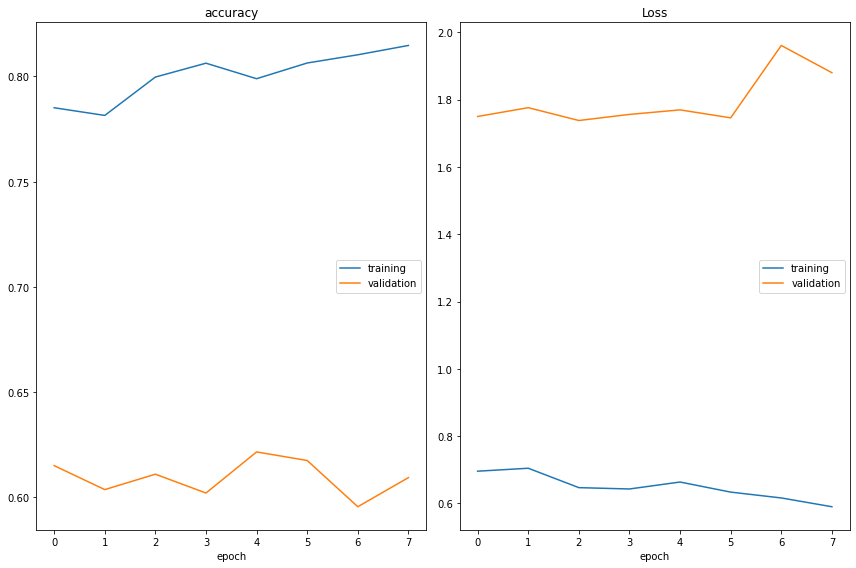

accuracy
	training         	 (min:    0.781, max:    0.815, cur:    0.815)
	validation       	 (min:    0.596, max:    0.622, cur:    0.609)
Loss
	training         	 (min:    0.590, max:    0.705, cur:    0.590)
	validation       	 (min:    1.738, max:    1.961, cur:    1.880)
361/361 [==============================] - 205s 568ms/step - loss: 0.5901 - accuracy: 0.8147 - val_loss: 1.8800 - val_accuracy: 0.6094


In [ ]:
# Training stopped too early, so I train the model again.
# Accuracy and loss were very unstable the previous time,
# so I don't expect accuracy to jump much higher.
my_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[stop_early, save_weights, PlotLossesKeras()],
)

## Testing

In [ ]:
my_model.evaluate(test_generator)

29/29 [==============================] - 12s 398ms/step - loss: 1.6879 - accuracy: 0.6501


[1.687925934791565, 0.650053858757019]

In [ ]:
output, labels = test_model(my_model)
output, output.shape, labels, labels.shape

(array([[6.26467168e-04, 4.93655489e-06, 4.44859639e-03, ...,
         1.43069110e-06, 2.41184971e-05, 3.84097211e-06],
        [3.64551482e-08, 5.53325696e-14, 1.92967572e-10, ...,
         1.36696832e-09, 2.56426976e-12, 2.45306027e-14],
        [4.05700303e-06, 2.90051483e-10, 1.91761274e-07, ...,
         1.24347725e-05, 6.76991588e-11, 2.14303811e-10],
        ...,
        [3.89983267e-01, 6.10399752e-07, 7.12171372e-04, ...,
         1.29506925e-05, 5.27978656e-08, 7.22506996e-08],
        [1.42090919e-03, 5.98507199e-08, 4.25673534e-06, ...,
         3.03639285e-03, 1.57761306e-07, 1.15542269e-08],
        [7.29536760e-06, 2.42918716e-08, 3.06257698e-06, ...,
         1.86613160e-08, 1.47888585e-07, 4.86511844e-08]], dtype=float32),
 (3712, 104),
 array([75, 68, 38, ...,  0, 54,  6]),
 (3712,))

In [ ]:
predicted_labels = get_predicted_labels(output)
predicted_labels, predicted_labels.shape

(array([75, 68, 38, ...,  0, 54,  6]), (3712,))

In [ ]:
confusion_matrix = get_confusion_matrix(labels, predicted_labels)
confusion_matrix

,pink primrose,hard-leaved pocket orchid,canterbury bells,sweet pea,wild geranium,tiger lily,moon orchid,bird of paradise,monkshood,globe thistle,...,bougainvillea,camellia,mallow,mexican petunia,bromelia,blanket flower,trumpet creeper,blackberry lily,common tulip,wild rose
pink primrose,59,0,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,1,0,0,0
hard-leaved pocket orchid,0,4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
canterbury bells,0,0,7,0,1,0,1,0,0,0,...,1,0,0,1,2,0,1,0,0,0
sweet pea,0,0,0,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wild geranium,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blanket flower,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,18,1,0,0,0
trumpet creeper,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,12,0,0,0
blackberry lily,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
common tulip,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0


In [ ]:
f1_score = compute_f1score(output, labels)
f1_score

array([0.76623374, 0.61538464, 0.27450982, 0.16666666, 0.62500006,
       0.60747665, 0.7136364 , 0.54545456, 0.7924528 , 0.74025977,
       0.705036  , 0.        , 0.75      , 0.4761905 , 0.54999995,
       0.5       , 0.2       , 0.9230769 , 0.59999996, 0.88      ,
       0.8       , 0.52380955, 0.6296297 , 0.8333334 , 0.44444448,
       0.675     , 0.3846154 , 0.        , 0.25581396, 0.21052633,
       0.30769232, 0.44444448, 0.6666667 , 0.90000004, 0.9411765 ,
       0.7692307 , 0.        , 0.5405406 , 0.7291667 , 0.6206897 ,
       0.5106383 , 0.24242423, 0.6197183 , 0.6       , 0.69306934,
       0.46376812, 0.65909094, 0.76106197, 0.75      , 0.5614035 ,
       0.55      , 0.56000006, 0.47272727, 0.7361111 , 0.8148148 ,
       0.9375    , 0.78431374, 0.9230769 , 1.        , 0.9714286 ,
       0.57142854, 1.        , 0.7142857 , 0.779661  , 0.93333334,
       0.969697  , 0.9473684 , 0.4       , 0.7909091 , 0.61538464,
       0.5       , 0.9032258 , 0.5833333 , 0.45      , 0.79591

In [ ]:
# Macro F1 score
np.average(f1_score)

0.61001104

In [ ]:
most_confusing_classes(count=6, f1_score=f1_score)

['cape flower',
 'stemless gentian',
 "colt's foot",
 'sweet pea',
 'watercress',
 'purple coneflower']

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      3

# VGG19 With Pre-Trained Weights

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

vgg19 = Sequential([
    VGG19(include_top=False, weights='imagenet', pooling='max', input_shape=(256, 256, 3)),
    Dense(4096, activation="relu"),
    Dense(4096, activation="relu"),
    Dense(104, activation='softmax'),
])

vgg19.compile(optimizer=Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics='accuracy')

In [ ]:
vgg19.load_weights('/content/drive/MyDrive/Checkpoint/VGG19/checkpoint')

## Training

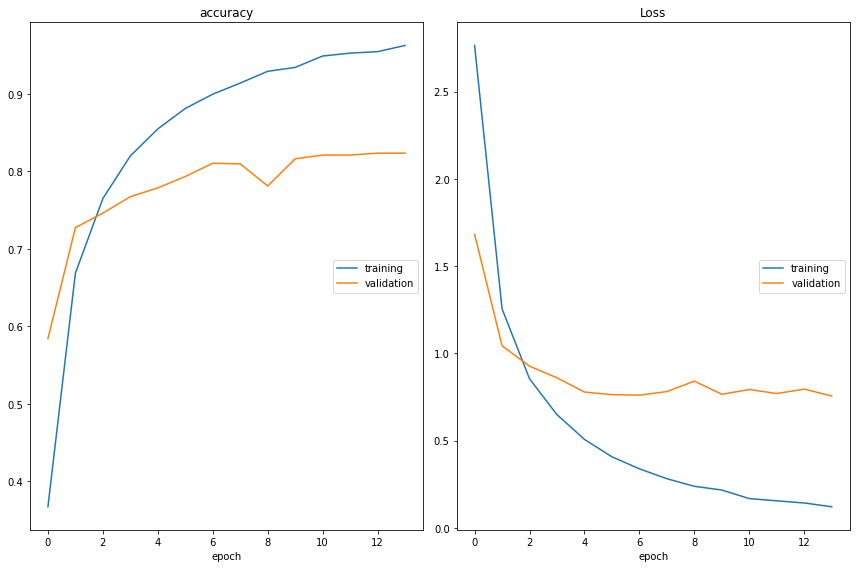

accuracy
	training         	 (min:    0.367, max:    0.962, cur:    0.962)
	validation       	 (min:    0.584, max:    0.823, cur:    0.823)
Loss
	training         	 (min:    0.121, max:    2.764, cur:    0.121)
	validation       	 (min:    0.755, max:    1.682, cur:    0.755)
361/361 [==============================] - 300s 830ms/step - loss: 0.1210 - accuracy: 0.9623 - val_loss: 0.7552 - val_accuracy: 0.8234
Epoch 15/25
343/361 [===========================>..] - ETA: 13s - loss: 0.1080 - accuracy: 0.9640

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

# ModelCheckpoint callback - save best weights
vgg19_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Checkpoint/VGG19/checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

stop_early = EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True
)

vgg19_history = vgg19.fit(train_generator,
                          epochs=25,
                          validation_data=validation_generator,
                          callbacks=[vgg19_checkpoint, stop_early, PlotLossesKeras()])

## Testing




In [ ]:
vgg19.evaluate(test_generator)

29/29 [==============================] - 52s 1s/step - loss: 0.8649 - accuracy: 0.8225


[0.8649457693099976, 0.8224676847457886]

In [ ]:
output, labels = test_model(vgg19)
output, output.shape, labels, labels.shape

(array([[6.0949972e-08, 8.2726069e-11, 6.4744534e-05, ..., 4.8711777e-12,
         8.4748458e-11, 2.9478006e-10],
        [2.6615418e-10, 1.1439232e-09, 9.0633817e-05, ..., 4.6333329e-10,
         1.8735229e-05, 5.7454115e-12],
        [1.0039320e-12, 9.2258373e-13, 2.2293959e-07, ..., 1.1530761e-17,
         6.6397842e-14, 7.7428678e-17],
        ...,
        [2.9837419e-12, 5.0314655e-09, 1.2687253e-12, ..., 1.5743802e-12,
         6.3393290e-13, 1.6279184e-14],
        [9.2683113e-06, 2.7882388e-08, 1.5231407e-07, ..., 3.4681382e-09,
         5.5686336e-09, 2.9756528e-09],
        [5.5597070e-06, 9.2140335e-06, 1.1736066e-08, ..., 1.3418751e-10,
         2.2079611e-09, 4.9526175e-08]], dtype=float32),
 (3712, 104),
 array([ 5, 73, 75, ..., 84, 75,  9]),
 (3712,))

In [ ]:
predicted_labels = get_predicted_labels(output)
predicted_labels, predicted_labels.shape

(array([ 5, 73, 75, ..., 84, 75,  9]), (3712,))

In [ ]:
confusion_matrix = get_confusion_matrix(labels, predicted_labels)
confusion_matrix

,pink primrose,hard-leaved pocket orchid,canterbury bells,sweet pea,wild geranium,tiger lily,moon orchid,bird of paradise,monkshood,globe thistle,...,bougainvillea,camellia,mallow,mexican petunia,bromelia,blanket flower,trumpet creeper,blackberry lily,common tulip,wild rose
pink primrose,65,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hard-leaved pocket orchid,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
canterbury bells,0,0,30,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sweet pea,0,0,1,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wild geranium,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blanket flower,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,22,0,0,0,0
trumpet creeper,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,2,16,0,0,0
blackberry lily,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,0,0
common tulip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0


In [ ]:
f1_score = compute_f1score(output, labels)
f1_score

array([0.8965517 , 0.9230769 , 0.625     , 0.8235294 , 0.72727275,
       0.7706422 , 0.8591885 , 0.84615386, 0.875     , 0.8491621 ,
       0.90510947, 0.8333333 , 0.9142857 , 0.84615386, 0.70370364,
       0.84210527, 0.44444448, 0.8       , 0.754717  , 0.9285714 ,
       0.90909094, 0.78048784, 0.8510638 , 0.9230769 , 0.8695652 ,
       0.78125   , 0.7741936 , 0.14285713, 0.76363635, 0.5454545 ,
       0.59999996, 0.9230769 , 1.        , 0.90909094, 1.        ,
       0.85714287, 0.18181819, 0.6122449 , 0.83438146, 0.9444444 ,
       0.8235294 , 0.5581395 , 0.7462687 , 0.72727275, 0.82      ,
       0.84931505, 0.89041096, 0.85470086, 0.9141104 , 0.6896551 ,
       0.8108108 , 0.8679245 , 0.75      , 0.8504984 , 0.88      ,
       0.969697  , 0.7659574 , 0.9189189 , 0.95238096, 1.        ,
       1.        , 0.93333334, 0.61538464, 0.77272725, 0.93333334,
       0.969697  , 1.        , 0.5       , 0.9237473 , 0.64566934,
       0.8571429 , 0.9508197 , 0.76      , 0.74666667, 0.73684

In [ ]:
# Macro F1 Score
np.average(f1_score)

0.80155957

In [ ]:
most_confusing_classes(count=6, f1_score=f1_score)

['stemless gentian',
 'cape flower',
 'purple coneflower',
 'iris',
 'watercress',
 'sweet william']

# VGG16 From Scratch

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

vgg16s = Sequential([
    Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(256, 256, 3)),
    Conv2D(filters=64, kernel_size=3, padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=128, kernel_size=3, padding='same'),
    Conv2D(filters=128, kernel_size=3, padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=256, kernel_size=3, padding='same'),
    Conv2D(filters=256, kernel_size=3, padding='same'),
    Conv2D(filters=256, kernel_size=3, padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=512, kernel_size=3, padding='same'),
    Conv2D(filters=512, kernel_size=3, padding='same'),
    Conv2D(filters=512, kernel_size=3, padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=512, kernel_size=3, padding='same'),
    Conv2D(filters=512, kernel_size=3, padding='same'),
    Conv2D(filters=512, kernel_size=3, padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),

    Flatten(),
    Dense(units=4096, activation ='relu'),
    Dense(units=4096, activation ='relu'),
    Dense(len(CLASSES), activation='softmax')
])

vgg16s.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics='accuracy'
)

In [ ]:
vgg16s.load_weights('/content/drive/MyDrive/Checkpoint/VGG16/checkpoint')

## Training

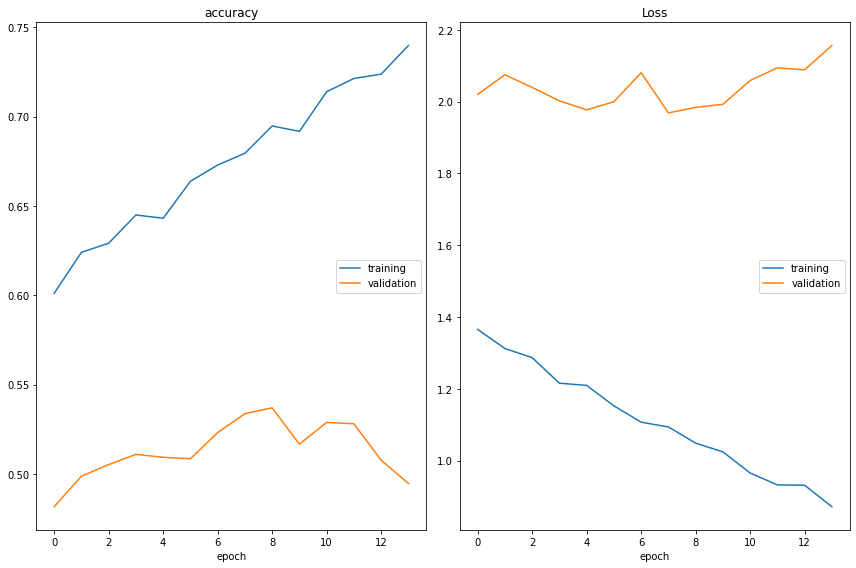

accuracy
	training         	 (min:    0.601, max:    0.740, cur:    0.740)
	validation       	 (min:    0.482, max:    0.537, cur:    0.495)
Loss
	training         	 (min:    0.871, max:    1.366, cur:    0.871)
	validation       	 (min:    1.969, max:    2.157, cur:    2.157)
361/361 [==============================] - 254s 704ms/step - loss: 0.8714 - accuracy: 0.7398 - val_loss: 2.1566 - val_accuracy: 0.4947


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

early_stopping = EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True, # restore the model back to the best state
)

# ModelCheckpoint callback - save best weights
vgg16_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Checkpoint/VGG16/checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

vgg16s_history = vgg16s.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[vgg16_checkpoint, early_stopping, PlotLossesKeras()]
)

## Testing


In [ ]:
vgg16s.evaluate(test_generator) # on 30 epochs

29/29 [==============================] - 24s 795ms/step - loss: 2.8348 - accuracy: 0.5515


[2.834768295288086, 0.5514547228813171]

In [ ]:
output, labels = test_model(vgg16s)
output, output.shape, labels, labels.shape

(array([[8.3808907e-17, 3.9057885e-21, 2.1905997e-08, ..., 1.6778796e-21,
         7.8669069e-07, 1.0588262e-15],
        [5.6501462e-23, 3.7762200e-23, 1.6809390e-06, ..., 1.7136258e-09,
         1.6843966e-16, 5.5958285e-18],
        [1.1354369e-03, 1.5723745e-11, 6.3388097e-07, ..., 9.4764075e-12,
         1.7220739e-11, 2.8386102e-13],
        ...,
        [8.3848751e-01, 5.2813714e-19, 3.8628190e-09, ..., 7.1561443e-15,
         7.2519112e-16, 1.6685343e-18],
        [1.7245780e-16, 2.1355900e-23, 2.5765919e-24, ..., 1.9358787e-21,
         1.3833100e-28, 1.4274268e-22],
        [1.7008396e-06, 1.0736847e-13, 1.2808441e-06, ..., 8.3163199e-12,
         4.2884388e-10, 2.1196796e-12]], dtype=float32),
 (3712, 104),
 array([48, 90, 19, ...,  9,  9, 56]),
 (3712,))

In [ ]:
predicted_labels = get_predicted_labels(output)
predicted_labels, predicted_labels.shape

(array([40, 90, 76, ...,  0,  9, 56]), (3712,))

In [ ]:
confusion_matrix = get_confusion_matrix(labels, predicted_labels)
confusion_matrix

,pink primrose,hard-leaved pocket orchid,canterbury bells,sweet pea,wild geranium,tiger lily,moon orchid,bird of paradise,monkshood,globe thistle,...,bougainvillea,camellia,mallow,mexican petunia,bromelia,blanket flower,trumpet creeper,blackberry lily,common tulip,wild rose
pink primrose,67,0,0,0,0,0,4,0,0,0,...,0,0,0,1,0,0,0,0,0,0
hard-leaved pocket orchid,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
canterbury bells,0,0,7,0,0,3,1,0,0,0,...,0,1,0,1,0,2,1,0,1,0
sweet pea,0,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wild geranium,0,0,0,0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blanket flower,1,0,0,0,0,1,4,0,0,0,...,0,0,0,0,0,13,0,0,0,0
trumpet creeper,1,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,6,1,0,0
blackberry lily,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
common tulip,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0


In [ ]:
f1_score = compute_f1score(output, labels)
f1_score

array([0.63507104, 0.61538464, 0.23333333, 0.30769232, 0.6666667 ,
       0.446281  , 0.59694993, 0.7741936 , 0.6101695 , 0.6538461 ,
       0.67164177, 0.2       , 0.8125    , 0.5185185 , 0.30769232,
       0.36363637, 0.25      , 0.6666667 , 0.625     , 0.45454547,
       0.6666667 , 0.5909091 , 0.54545456, 0.6666667 , 0.6666667 ,
       0.5066667 , 0.44444448, 0.        , 0.24561404, 0.13333334,
       0.33333334, 0.4       , 0.52631575, 0.90000004, 0.75862074,
       0.26666668, 0.        , 0.6       , 0.5522788 , 0.59090906,
       0.44444445, 0.35294116, 0.34920633, 0.3333333 , 0.7083334 ,
       0.54794526, 0.59756094, 0.6329114 , 0.6523077 , 0.56      ,
       0.4262295 , 0.45833334, 0.45000002, 0.6594203 , 0.625     ,
       0.9032258 , 0.7083333 , 0.9189189 , 0.82352936, 1.        ,
       0.40000004, 0.79999995, 0.61538464, 0.6296296 , 1.        ,
       0.8965517 , 1.        , 0.5       , 0.6666667 , 0.36220473,
       0.5063291 , 0.8727273 , 0.6       , 0.3809524 , 0.61538

In [ ]:
# Macro F1 score
np.average(f1_score)

0.52876085

In [ ]:
most_confusing_classes(count=6, f1_score=f1_score)

['stemless gentian',
 'cape flower',
 'blackberry lily',
 'bromelia',
 'sweet william',
 'clematis']

# ResNet50 With Pre-Trained Weights

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

resnet50 = Sequential([
    ResNet50(include_top=False, weights='imagenet', pooling='max'),
    Dense(104, activation='softmax')
])

# First used SFS, but found that it overfits the model with accuracy nearly 1.
# Changed to adam as it does better in terms of not overfitting.
resnet50.compile(optimizer=Adam(learning_rate=0.0001),
                 loss=SparseCategoricalCrossentropy(),
                 metrics='accuracy')

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet50.load_weights('/content/drive/MyDrive/Checkpoint/Resnet50_pre/checkpoint_resnetpre')

## Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras

save_weights_resnetpre = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Checkpoint/Resnet50_pre/checkpoint_resnetpre',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

resnet50_history = resnet50.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # Changing the number of epocs from 10 to 15 to get better accuracy.
    callbacks=[save_weights_resnetpre,PlotLossesKeras()],
)

## Testing

In [ ]:
resnet50.evaluate(test_generator)

29/29 [==============================] - 21s 524ms/step - loss: 1.0654 - accuracy: 0.8106


[1.0653655529022217, 0.8106142282485962]

In [ ]:
output, labels = test_model(resnet50)
output, output.shape, labels, labels.shape

(array([[1.2972278e-07, 1.5595066e-03, 2.0122453e-08, ..., 2.3093302e-05,
         2.7847300e-08, 2.8121114e-08],
        [5.5549510e-13, 2.7029115e-10, 1.3344922e-11, ..., 4.1269851e-14,
         2.1038772e-14, 3.2672121e-14],
        [4.6254430e-19, 2.6789144e-17, 3.2477304e-21, ..., 6.1821491e-24,
         3.3031746e-25, 2.0696071e-17],
        ...,
        [9.8125747e-06, 2.8034583e-07, 4.9466092e-08, ..., 2.4705568e-10,
         2.8074982e-07, 1.8773177e-11],
        [1.4316678e-04, 2.9230918e-07, 5.1596743e-07, ..., 1.6279998e-12,
         4.1837223e-09, 1.4541363e-05],
        [2.8023600e-10, 8.5715067e-07, 1.1132704e-05, ..., 2.6475263e-12,
         9.8185161e-08, 1.8163119e-12]], dtype=float32),
 (3712, 104),
 array([100,  87,  53, ...,  60,  75,  99]),
 (3712,))

In [ ]:
predicted_labels = get_predicted_labels(output)
predicted_labels, predicted_labels.shape

(array([100,  87,  53, ...,   6,  42,  99]), (3712,))

In [ ]:
confusion_matrix = get_confusion_matrix(labels, predicted_labels)
confusion_matrix

,pink primrose,hard-leaved pocket orchid,canterbury bells,sweet pea,wild geranium,tiger lily,moon orchid,bird of paradise,monkshood,globe thistle,...,bougainvillea,camellia,mallow,mexican petunia,bromelia,blanket flower,trumpet creeper,blackberry lily,common tulip,wild rose
pink primrose,75,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
hard-leaved pocket orchid,0,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
canterbury bells,0,0,17,1,0,0,2,0,0,0,...,0,0,0,1,1,0,0,0,0,0
sweet pea,0,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wild geranium,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blanket flower,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,31,1,0,0,0
trumpet creeper,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,17,0,0,0
blackberry lily,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
common tulip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0


In [ ]:
f1_score = compute_f1score(output, labels)
f1_score

array([0.82872933, 0.875     , 0.5862069 , 0.8235294 , 0.85714287,
       0.7817259 , 0.8639618 , 0.88      , 0.8679245 , 0.8044693 ,
       0.86713284, 0.85714287, 0.9677419 , 0.82758623, 0.70000005,
       0.88888896, 0.42105263, 0.6666667 , 0.7555555 , 0.9629629 ,
       0.8       , 0.7692308 , 0.8695652 , 0.72727275, 0.9473684 ,
       0.8709678 , 0.74285716, 0.15384616, 0.4285714 , 0.7692307 ,
       0.8333334 , 0.8       , 0.6666667 , 0.75      , 1.        ,
       0.7777778 , 0.3333333 , 0.6875    , 0.9002432 , 0.85      ,
       0.7346938 , 0.6470588 , 0.65822786, 0.75      , 0.79611653,
       0.7878788 , 0.77862597, 0.8515625 , 0.8524591 , 0.85106385,
       0.7704918 , 0.8518519 , 0.74576277, 0.8000001 , 0.7777778 ,
       0.9375    , 0.5952381 , 0.875     , 0.9473684 , 1.        ,
       0.6666667 , 1.        , 0.84210527, 0.88      , 0.94117653,
       0.94117653, 1.        , 0.6       , 0.9012876 , 0.794702  ,
       0.82142854, 0.91228074, 0.77966106, 0.6585366 , 0.91111

In [ ]:
# Macro F1 Score
np.average(f1_score)

0.7848455

In [ ]:
most_confusing_classes(count=6, f1_score=f1_score)

['stemless gentian',
 'cape flower',
 'purple coneflower',
 'artichoke',
 'mallow',
 'blackberry lily']

# ResNet50 From Scratch

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    x = Add()([tensor,x])
    x = ReLU()(x)
    return x

def projection_block(tensor, filters, strides):
    # left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)

    # right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut,x])
    x = ReLU()(x)
    return x

def resnet_block(x, filters, reps, strides):
    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = identity_block(x,filters)
    return x

In [ ]:
input = Input(shape=(256, 256, 3))

x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)
x = MaxPool2D(pool_size=3, strides=2)(x)
x = resnet_block(x, filters=64, reps=3, strides=1)
x = resnet_block(x, filters=128, reps=4, strides=2)
x = resnet_block(x, filters=256, reps=6, strides=2)
x = resnet_block(x, filters=512, reps=3, strides=2)
x = GlobalAvgPool2D()(x)

output = Dense(104, activation='softmax')(x)

resnet50s = Model(inputs=input, outputs=output)

In [ ]:
resnet50s.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(),
                  metrics='accuracy')

In [ ]:
resnet50s.load_weights('/content/drive/MyDrive/Checkpoint/Resnet50/checkpoint_resnet')

## Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras

save_weights_resnet = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Checkpoint/Resnet50/checkpoint_resnet',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

resnet50s_history = resnet50s.fit(train_generator,
                                  validation_data=validation_generator,
                                  epochs=35,
                                  callbacks=[save_weights_resnet, PlotLossesKeras()])

## Testing

In [ ]:
resnet50s.evaluate(test_generator)

29/29 [==============================] - 22s 639ms/step - loss: 1.2908 - accuracy: 0.6926


[1.2908401489257812, 0.6926185488700867]

In [ ]:
output, labels = test_model(resnet50s)
output, output.shape, labels, labels.shape

(array([[9.9030709e-01, 9.5036242e-08, 2.7828755e-06, ..., 5.8676932e-07,
         3.1217112e-10, 1.4109983e-16],
        [7.0890975e-01, 6.7329648e-07, 7.6040009e-04, ..., 1.2109068e-04,
         8.4840110e-07, 1.0658792e-12],
        [1.2082377e-05, 5.0318445e-04, 9.1857673e-06, ..., 8.2970658e-08,
         4.2597526e-10, 1.0284327e-10],
        ...,
        [6.6211086e-21, 1.0492248e-18, 1.7374593e-17, ..., 9.1513833e-22,
         1.9916032e-14, 1.5850565e-08],
        [5.9787168e-11, 7.9969783e-14, 7.6579888e-11, ..., 5.0743830e-14,
         1.5263113e-10, 2.8926108e-09],
        [2.4918574e-04, 7.6356380e-05, 3.7681975e-06, ..., 2.4915069e-05,
         3.3090036e-10, 2.2745298e-13]], dtype=float32),
 (3712, 104),
 array([ 0, 44, 15, ..., 53,  7, 77]),
 (3712,))

In [ ]:
predicted_labels = get_predicted_labels(output)
predicted_labels, predicted_labels.shape

(array([ 0,  0,  6, ..., 53, 48, 76]), (3712,))

In [ ]:
confusion_matrix = get_confusion_matrix(labels, predicted_labels)
confusion_matrix

,pink primrose,hard-leaved pocket orchid,canterbury bells,sweet pea,wild geranium,tiger lily,moon orchid,bird of paradise,monkshood,globe thistle,...,bougainvillea,camellia,mallow,mexican petunia,bromelia,blanket flower,trumpet creeper,blackberry lily,common tulip,wild rose
pink primrose,59,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hard-leaved pocket orchid,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
canterbury bells,0,0,12,0,0,3,2,0,0,0,...,0,1,0,0,1,0,0,0,0,0
sweet pea,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wild geranium,0,0,0,0,4,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blanket flower,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,19,1,0,0,0
trumpet creeper,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,15,0,0,0
blackberry lily,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
common tulip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0


In [ ]:
f1_score = compute_f1score(output, labels)
f1_score

array([0.8082192 , 0.72727275, 0.42857146, 0.        , 0.72727275,
       0.6206897 , 0.77727276, 0.5555555 , 0.78431374, 0.77241373,
       0.76363635, 0.22222224, 0.8108108 , 0.7333333 , 0.4745763 ,
       0.48000005, 0.2       , 0.7692307 , 0.6666666 , 0.82758623,
       0.5       , 0.65384614, 0.53731346, 1.        , 0.30769232,
       0.78125   , 0.4390244 , 0.        , 0.05555556, 0.42105266,
       0.72727275, 0.6666667 , 0.5714286 , 0.6666667 , 1.        ,
       0.7058823 , 0.3333333 , 0.7       , 0.82125604, 0.78787875,
       0.4927536 , 0.36363637, 0.64000005, 0.57142854, 0.7311828 ,
       0.5789474 , 0.73134327, 0.75313807, 0.7616279 , 0.6       ,
       0.63736266, 0.8076923 , 0.51063836, 0.79693484, 0.8000001 ,
       1.        , 0.76000005, 0.9473684 , 0.95238096, 1.        ,
       0.36363637, 0.93333334, 0.631579  , 0.6956522 , 0.93333334,
       0.7804878 , 1.        , 0.6       , 0.83010757, 0.6760563 ,
       0.5263158 , 0.7567568 , 0.6530612 , 0.5168539 , 0.87500

In [ ]:
# Macro F1 Score
np.average(f1_score)

0.645457

In [ ]:
most_confusing_classes(count=6, f1_score=f1_score)

['sweet pea',
 'stemless gentian',
 'artichoke',
 'purple coneflower',
 "colt's foot",
 'mallow']

# Ensemble Model

In [ ]:
models = [resnet50s, my_model] # stacking individual models in a list
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models] # collects outputs of models in a list
ensemble_output = tf.keras.layers.Average()(model_outputs) # averaging outputs
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.compile(optimizer=Adam(learning_rate=5e-4, epsilon = 0.1),
                       loss=SparseCategoricalCrossentropy(),
                       metrics='accuracy')

In [ ]:
ensemble_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 104)          23800808    ['input_2[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 104)          40080136    ['input_2[0][0]']                
                                                                                                  
 average (Average)              (None, 104)          0           ['model[0][0]',            

In [ ]:
ensemble_model.load_weights('/content/drive/MyDrive/Checkpoint/Ensemble_model/checkpoint')

## Training

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

early_stopping = EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True, # restore the model back to the best state
)

# ModelCheckpoint callback - save best weights
ensemble_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Checkpoint/Ensemble_model/checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

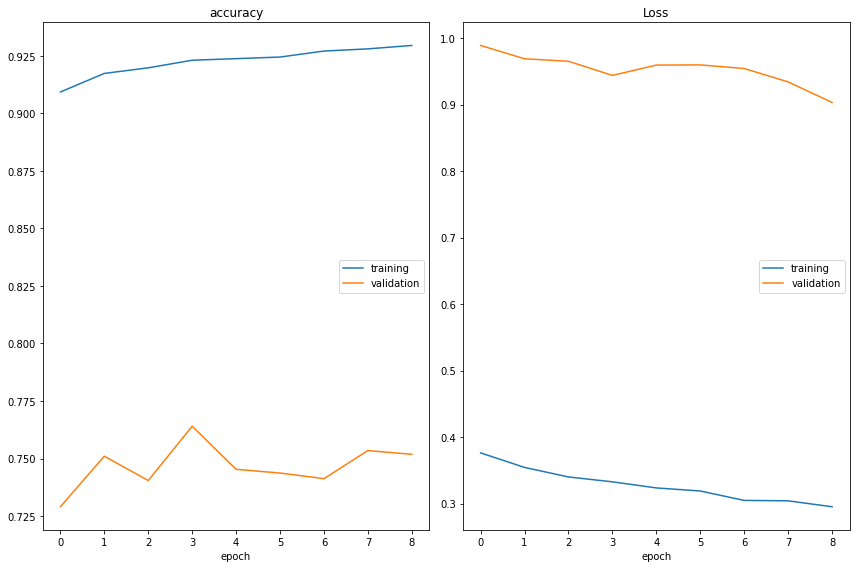

accuracy
	training         	 (min:    0.909, max:    0.930, cur:    0.930)
	validation       	 (min:    0.729, max:    0.764, cur:    0.752)
Loss
	training         	 (min:    0.295, max:    0.376, cur:    0.295)
	validation       	 (min:    0.903, max:    0.989, cur:    0.903)
361/361 [==============================] - 254s 704ms/step - loss: 0.2954 - accuracy: 0.9295 - val_loss: 0.9034 - val_accuracy: 0.7518


In [ ]:
ensemble_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[ensemble_checkpoint, early_stopping, PlotLossesKeras()]
)

## Testing

In [ ]:
ensemble_model.evaluate(test_generator)

29/29 [==============================] - 27s 661ms/step - loss: 0.9909 - accuracy: 0.7597


[0.9909319877624512, 0.7596982717514038]

In [ ]:
output, labels = test_model(ensemble_model)
output, output.shape, labels, labels.shape

(array([[1.45394867e-02, 1.83063378e-07, 1.38662628e-07, ...,
         9.59215777e-06, 4.70481654e-09, 4.77017501e-08],
        [1.83899065e-05, 4.82920193e-09, 7.39992814e-08, ...,
         1.21128219e-10, 1.22980550e-08, 1.36512766e-08],
        [4.16141283e-03, 2.39243265e-03, 1.05149475e-07, ...,
         9.86751729e-06, 1.85866520e-05, 1.07122389e-06],
        ...,
        [3.72350382e-06, 1.54474833e-07, 3.07539449e-04, ...,
         1.01533396e-05, 1.74235938e-05, 3.54991414e-07],
        [1.78164168e-08, 2.45680892e-10, 4.70859050e-05, ...,
         2.84483756e-11, 7.16530121e-05, 8.27963106e-07],
        [5.77721539e-06, 1.15961174e-03, 3.20832811e-07, ...,
         1.20166093e-02, 7.42841177e-10, 4.63596450e-09]], dtype=float32),
 (3712, 104),
 array([ 6,  7, 38, ..., 82, 49, 85]),
 (3712,))

In [ ]:
predicted_labels = get_predicted_labels(output)
predicted_labels, predicted_labels.shape

(array([38,  7, 78, ..., 82, 49, 85]), (3712,))

In [ ]:
confusion_matrix = get_confusion_matrix(labels, predicted_labels)
confusion_matrix

,pink primrose,hard-leaved pocket orchid,canterbury bells,sweet pea,wild geranium,tiger lily,moon orchid,bird of paradise,monkshood,globe thistle,...,bougainvillea,camellia,mallow,mexican petunia,bromelia,blanket flower,trumpet creeper,blackberry lily,common tulip,wild rose
pink primrose,72,0,0,0,0,1,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hard-leaved pocket orchid,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
canterbury bells,0,0,18,0,1,1,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
sweet pea,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wild geranium,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blanket flower,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,19,1,0,0,0
trumpet creeper,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,19,0,0,0
blackberry lily,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,0,0
common tulip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0


In [ ]:
f1_score = compute_f1score(output, labels)
f1_score

array([0.90000004, 0.72727275, 0.57142854, 0.5       , 0.79999995,
       0.6696035 , 0.8063782 , 0.8181818 , 0.7636364 , 0.85      ,
       0.822695  , 0.6       , 0.9375    , 0.7586207 , 0.65384614,
       0.57142854, 0.2857143 , 1.        , 0.7755102 , 0.85714287,
       0.90909094, 0.6122449 , 0.7058823 , 0.90909094, 0.72727275,
       0.7301588 , 0.59701496, 0.        , 0.29629627, 0.39999998,
       0.61538464, 0.8       , 0.75      , 0.95238096, 0.9142857 ,
       0.875     , 0.75      , 0.7894737 , 0.8598131 , 0.8571428 ,
       0.5862069 , 0.42105263, 0.74285716, 0.72727275, 0.73684216,
       0.6904762 , 0.8322148 , 0.8362069 , 0.8117647 , 0.81632656,
       0.6915888 , 0.7777778 , 0.50000006, 0.7746479 , 0.95238096,
       1.        , 0.78431374, 0.9473684 , 1.        , 0.9714286 ,
       0.6       , 0.84210527, 0.85714287, 0.81632656, 1.        ,
       0.9142857 , 1.        , 0.25      , 0.8631579 , 0.6463415 ,
       0.7307693 , 0.90625   , 0.74509805, 0.6097561 , 0.94000

In [ ]:
# Macro F1 Score
np.average(f1_score)

0.73617995

In [ ]:
most_confusing_classes(count=6, f1_score=f1_score)

['stemless gentian',
 'iris',
 'purple coneflower',
 'artichoke',
 'sweet william',
 'daffodil']